# MLCommons Earthquake GPU Power Analysis
- Generates GPU Power Usage Graphics

In [1]:
import os
import re
import glob
import pickle
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import timedelta
import matplotlib.dates as md
import matplotlib.pyplot as plt

### Plotting Functions

In [2]:
def plot_power_usage(df, path, span='total', normalize=True):
    """ Create power usage plot and save figure.
    Args:
        df: power dataframe. 
        path: output path.
        span: 'total' or 'train' or 'avg'
        normalize: bool argument to normalize to number of epochs
    """
    fig = plt.figure(figsize=(8, 6), dpi=360)
    power_usage_dir = os.path.join(path,'power_usage')
    if not os.path.exists(power_usage_dir):
        os.mkdir(power_usage_dir)
    
    # augment data
    df['epochs'] = df['epochs'].astype(int)
    df.sort_values('epochs')   
    df['kWh/epoch_total'] = df['kWh_total']/df['epochs']
    df['kWh/epoch_fit'] = df['kWh_fit']/df['epochs']
    
    if span == 'total' and normalize == False:
        # plot total notebook epochs vs. kWh
        save_name = 'total_epoch_vs_watts'
        sns.barplot(x='epochs', y='kWh_total', hue='gpu',data=df) 
        plt.title('Total Notebook: Epochs vs. kWh')
        plt.ylabel('kWh')

    if span == 'total' and normalize == True:
        # plot total notebook kWh per Epoch plot
        save_name = 'total_kWh_per_epoch'
        sns.barplot(x='epochs', y='kWh/epoch_total', hue='gpu',data=df) 
        plt.title('Total Notebook: Epochs vs. kWh/Epoch')
        plt.ylabel('kWh/epoch')
    
    if span == 'train' and normalize == False:
        # plot model fit epochs vs. kWh
        save_name = 'model_fit_epoch_vs_watts'
        sns.barplot(x='epochs', y='kWh_fit', hue='gpu',data=df) 
        plt.title('Model Fit: Epochs vs. kWh') 
        plt.ylabel('kWh')
    
    if span == 'train' and normalize == True:
        # plot model fit kWh per Epoch plot
        save_name = 'model_fit_kWh_per_epoch'
        sns.set_style("whitegrid")
        sns.barplot(x='epochs', y='kWh/epoch_fit', hue='gpu',data=df) 
        plt.title('Model Fit: Epochs vs. kWh/Epoch')
        plt.ylabel('kWh/epoch')
    
    if span == 'avg' and normalize == True:
        # plot average model fit kWh per Epoch
        save_name = 'average_kWh_per_epoch'
        grouped = df.groupby('gpu').mean()['kWh/epoch_fit'].reset_index()
        sns.set_style("whitegrid")
        sns.barplot(x="gpu", y="kWh/epoch_fit", data=grouped)
        plt.title('Average kWh/Epoch per GPU', fontsize=14)
        plt.ylabel('kWh/epoch', fontsize=12)
        plt.xlabel('GPU', fontsize=12)
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
    plot, _ = SAVEFIG(fig, save_name, power_usage_dir)
    plt.show()
    plt.close(fig)

In [3]:
def SAVEFIG(fig, filename, path=None, formats=('png', 'pdf')):
    fileout = os.path.join(path,filename)
    for my_format in formats:
        fig.savefig(f"{fileout}.{my_format}", format=my_format, bbox_inches="tight")
    return 1, tuple(f'{fileout}.{fmt}' for fmt in formats)

### Load Pickle

In [4]:
cwd = os.getcwd()
pickle_file = os.path.join(cwd,'experiment_data.pkl')
with open(pickle_file, 'rb') as f:
    loaded_dict = pickle.load(f)

In [5]:
out_dir = "analysis/power_usage"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

### Display Available Data

In [6]:
data = pd.DataFrame()
for experiment in loaded_dict.keys():
    run = {}
    gpu = loaded_dict[experiment]['run_info']['gpu']
    system = loaded_dict[experiment]['run_info']['system']
    filesystem = loaded_dict[experiment]['run_info']['filesystem']
    run['count'] = 1
    run['sys'] = f"{gpu}-{system}-{filesystem}"
    run_df = pd.DataFrame([run])
    data = pd.concat([data, run_df], ignore_index=True) 
data.groupby('sys').count()

,count
sys,
A100-rivanna-project,9
A100-rivanna-scratch,3
P100-colab-colab,3
V100-rivanna-localscratch,9
a100-rivanna-project,2
a100-rivanna-rivanna,1
a100-rivanna-shm,18
a100-rivanna_dgx-localscratch,18
k80-rivanna-project,2


### Create Analysis Outputs

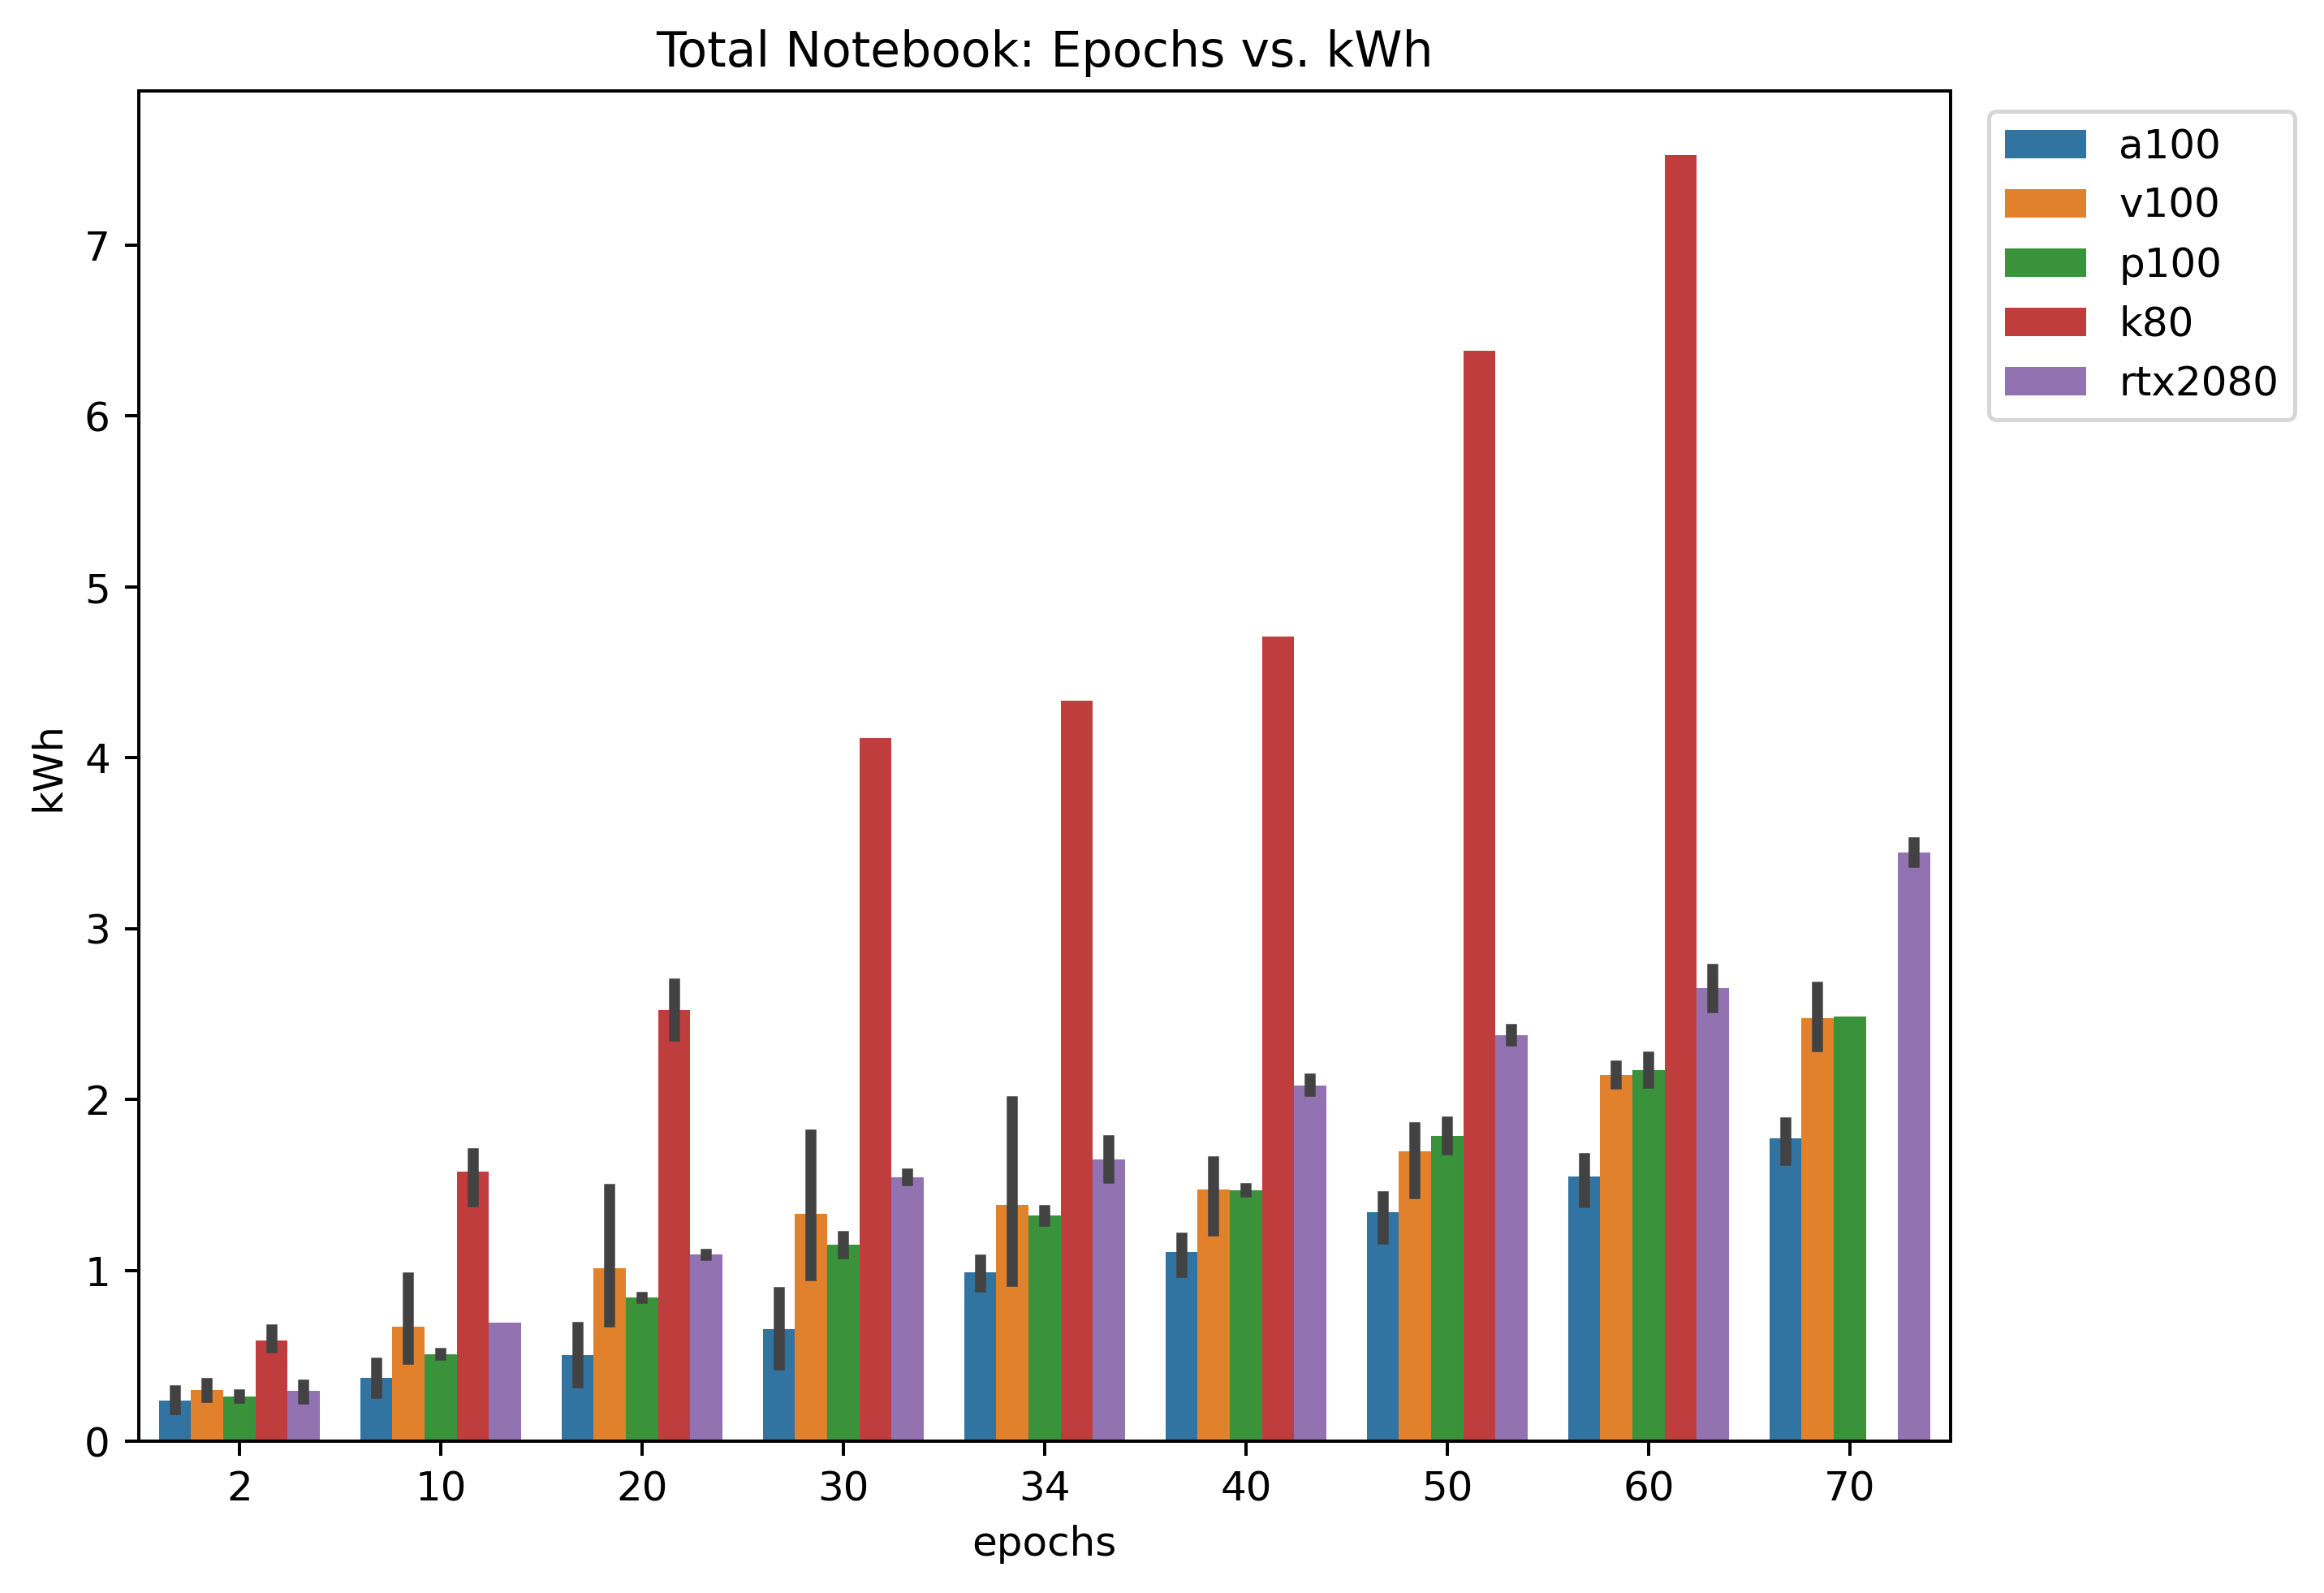

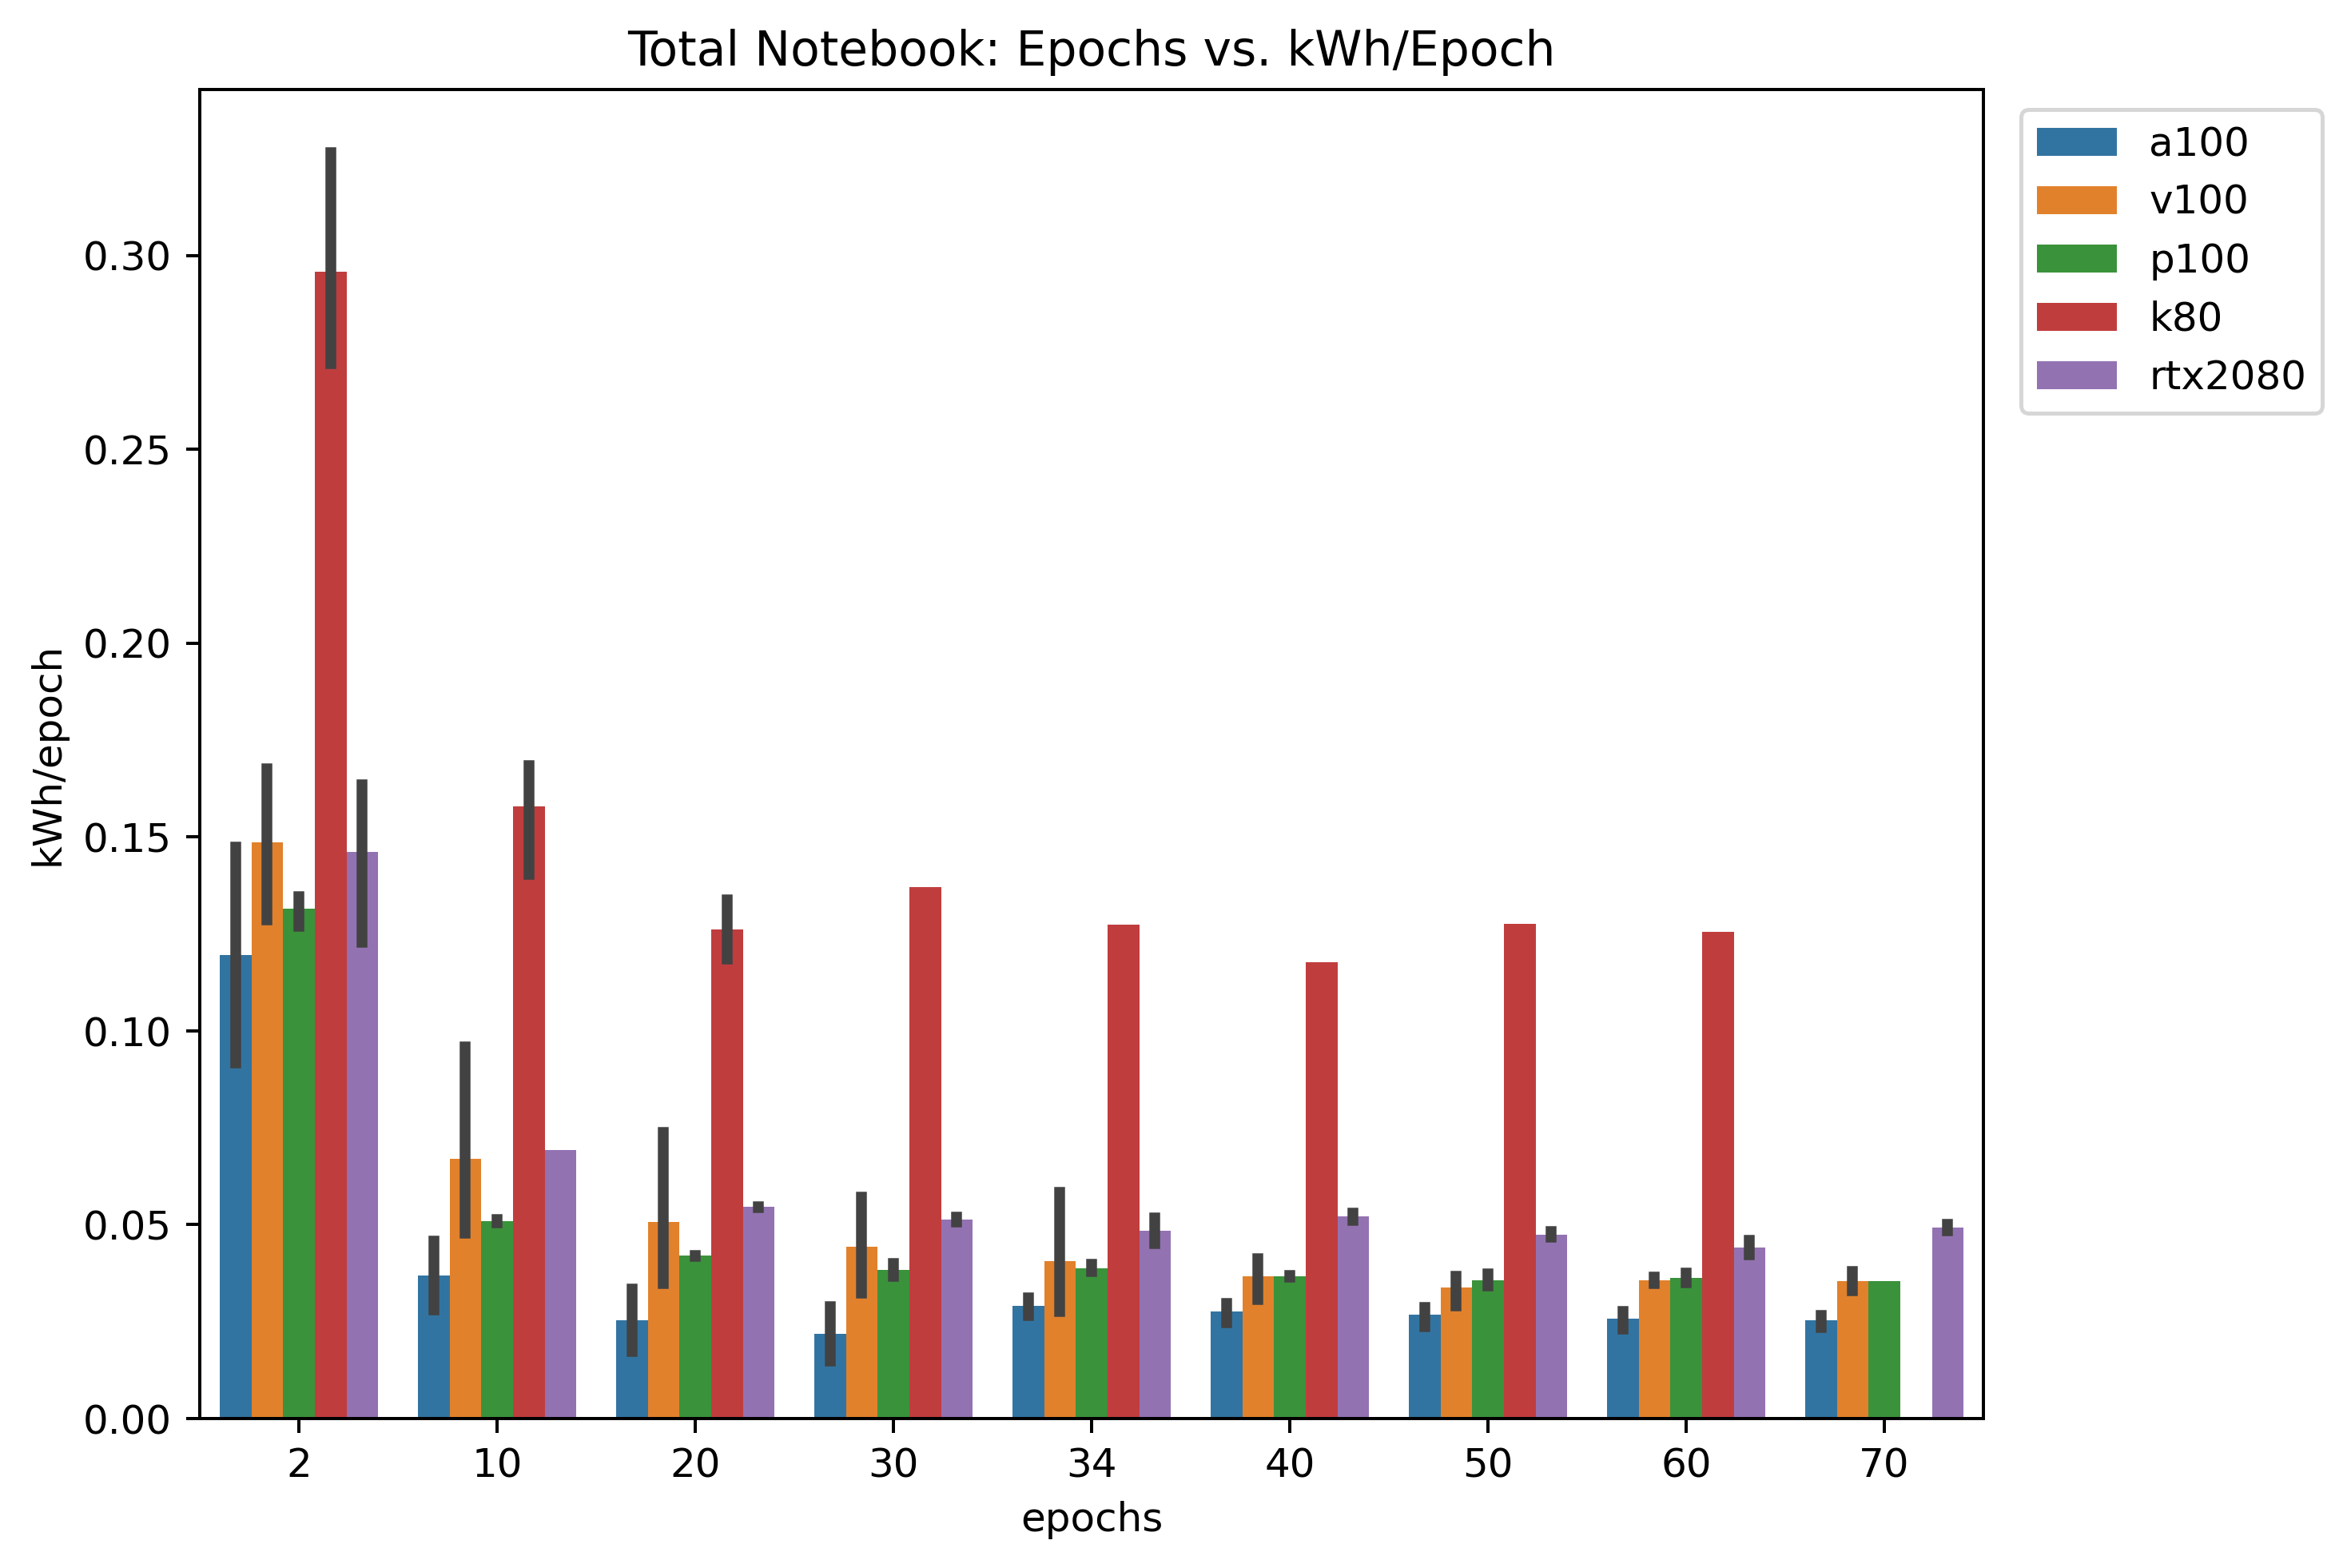

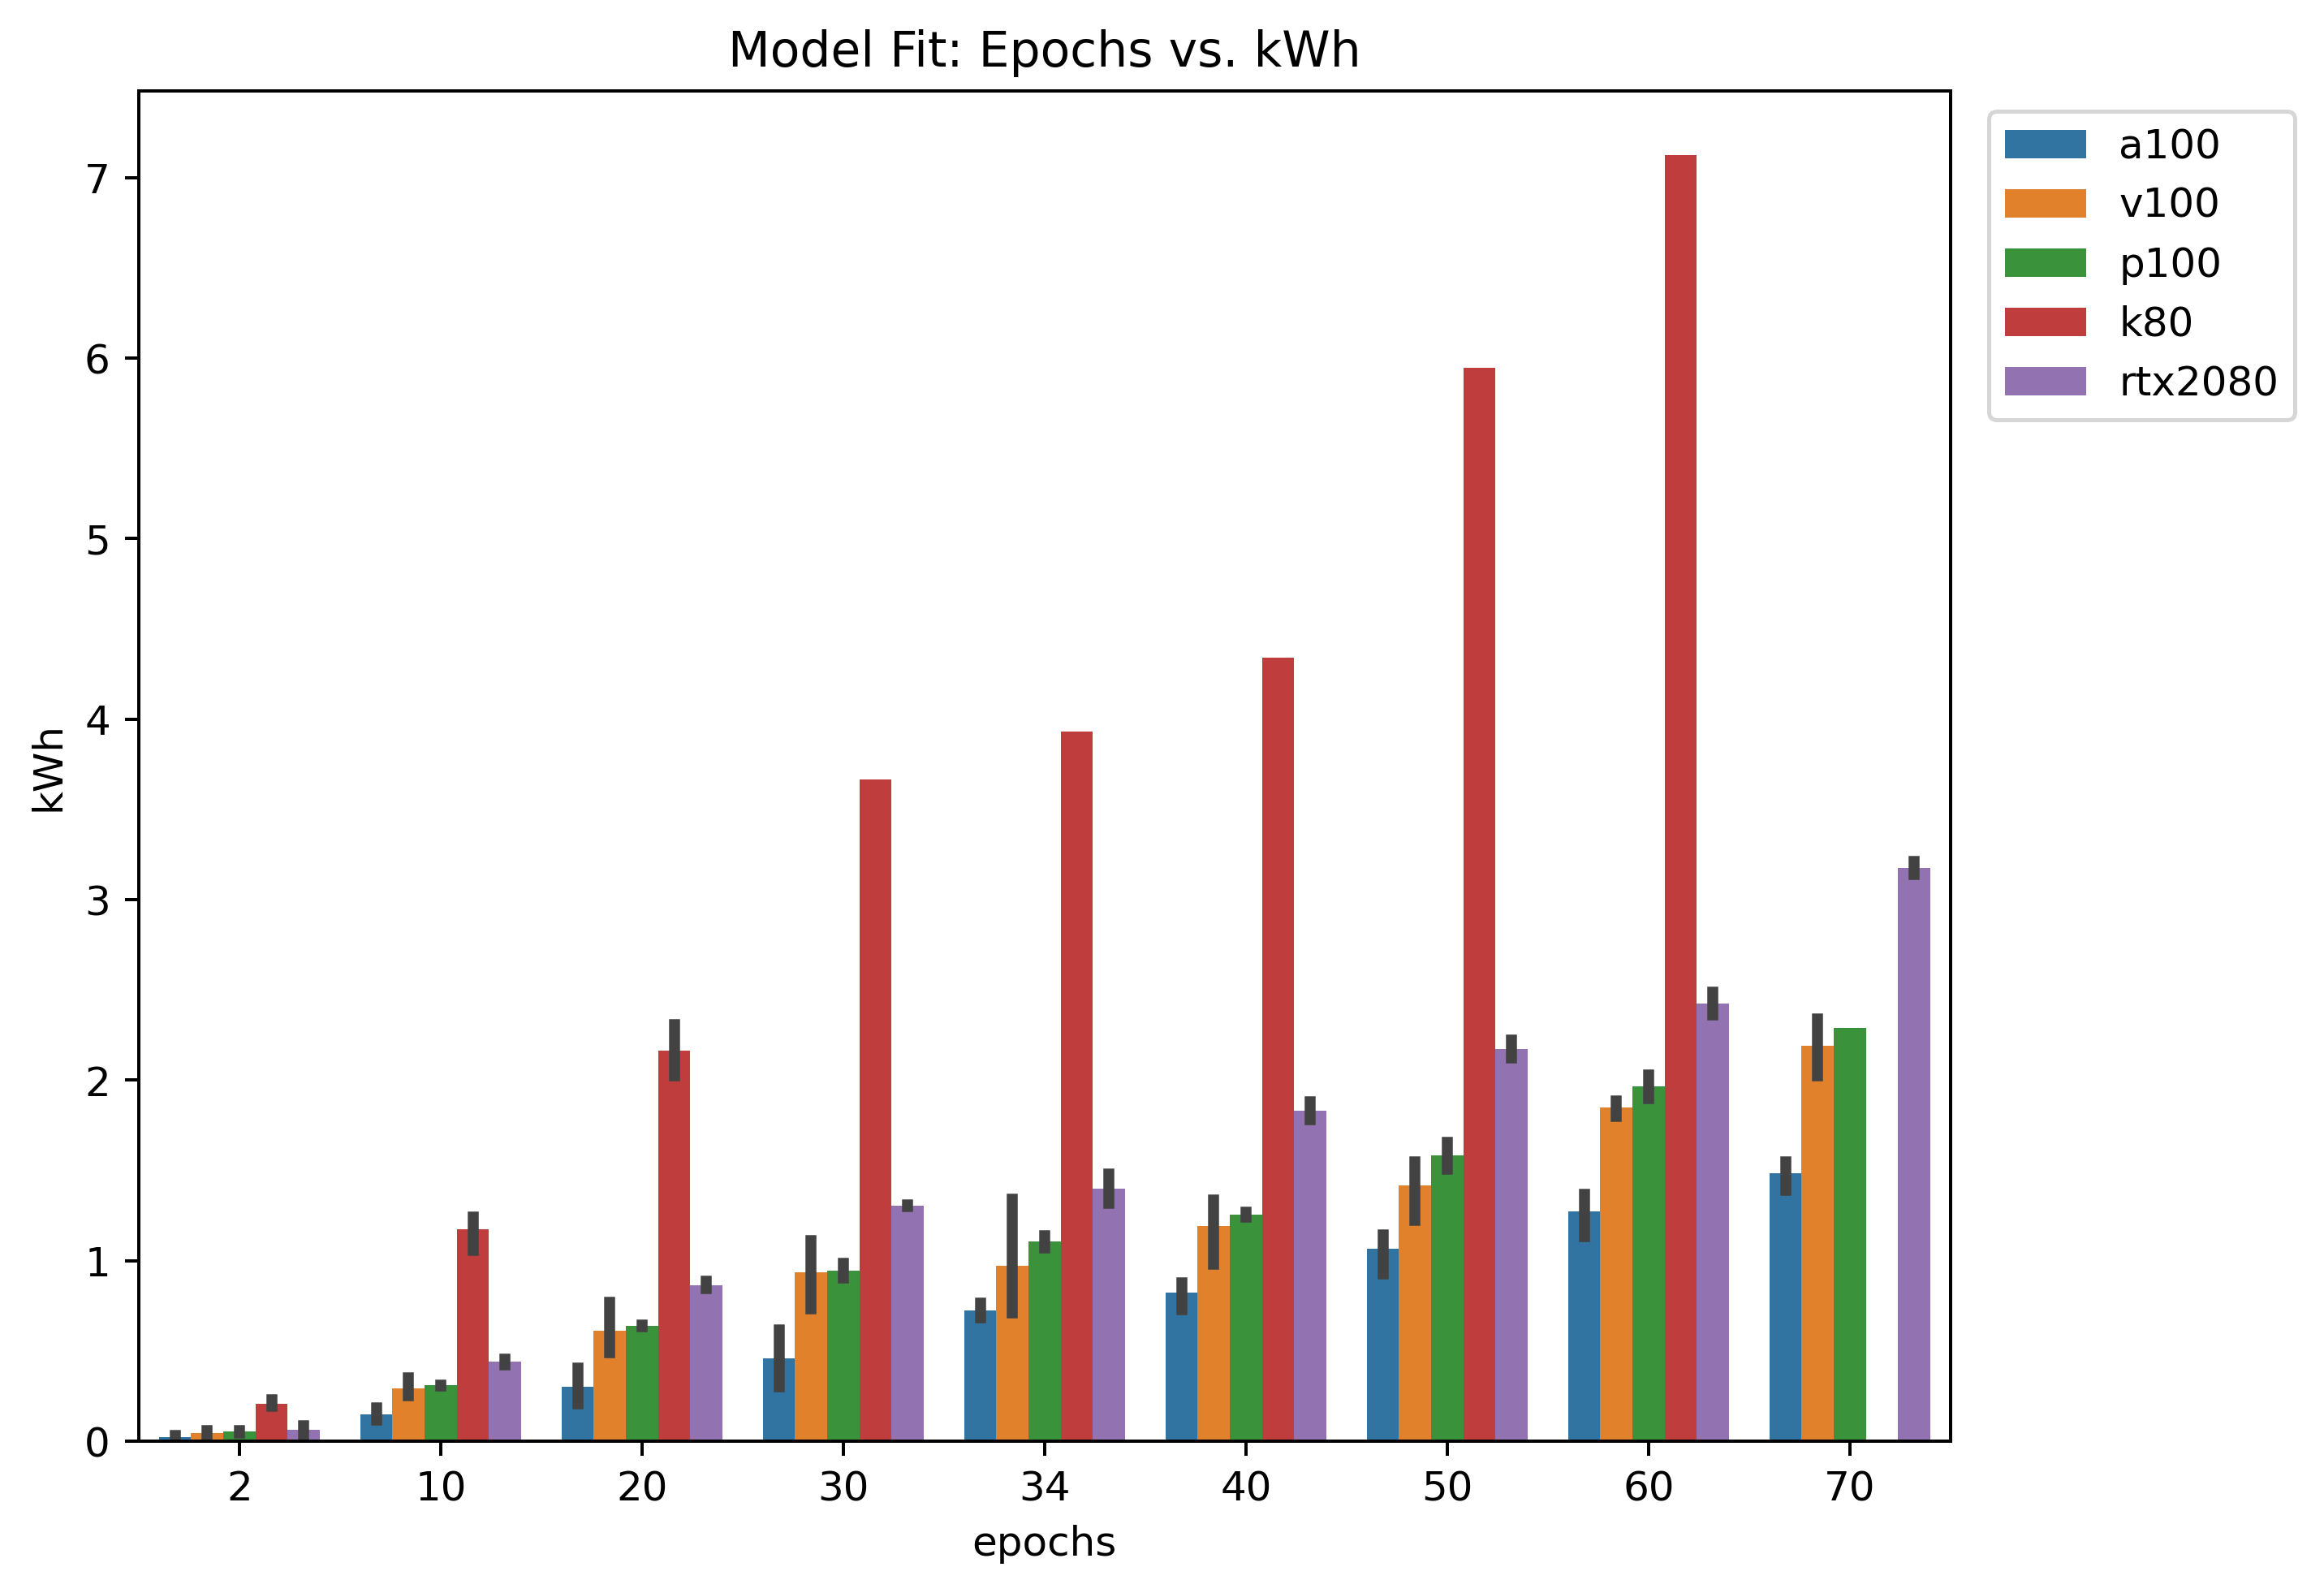

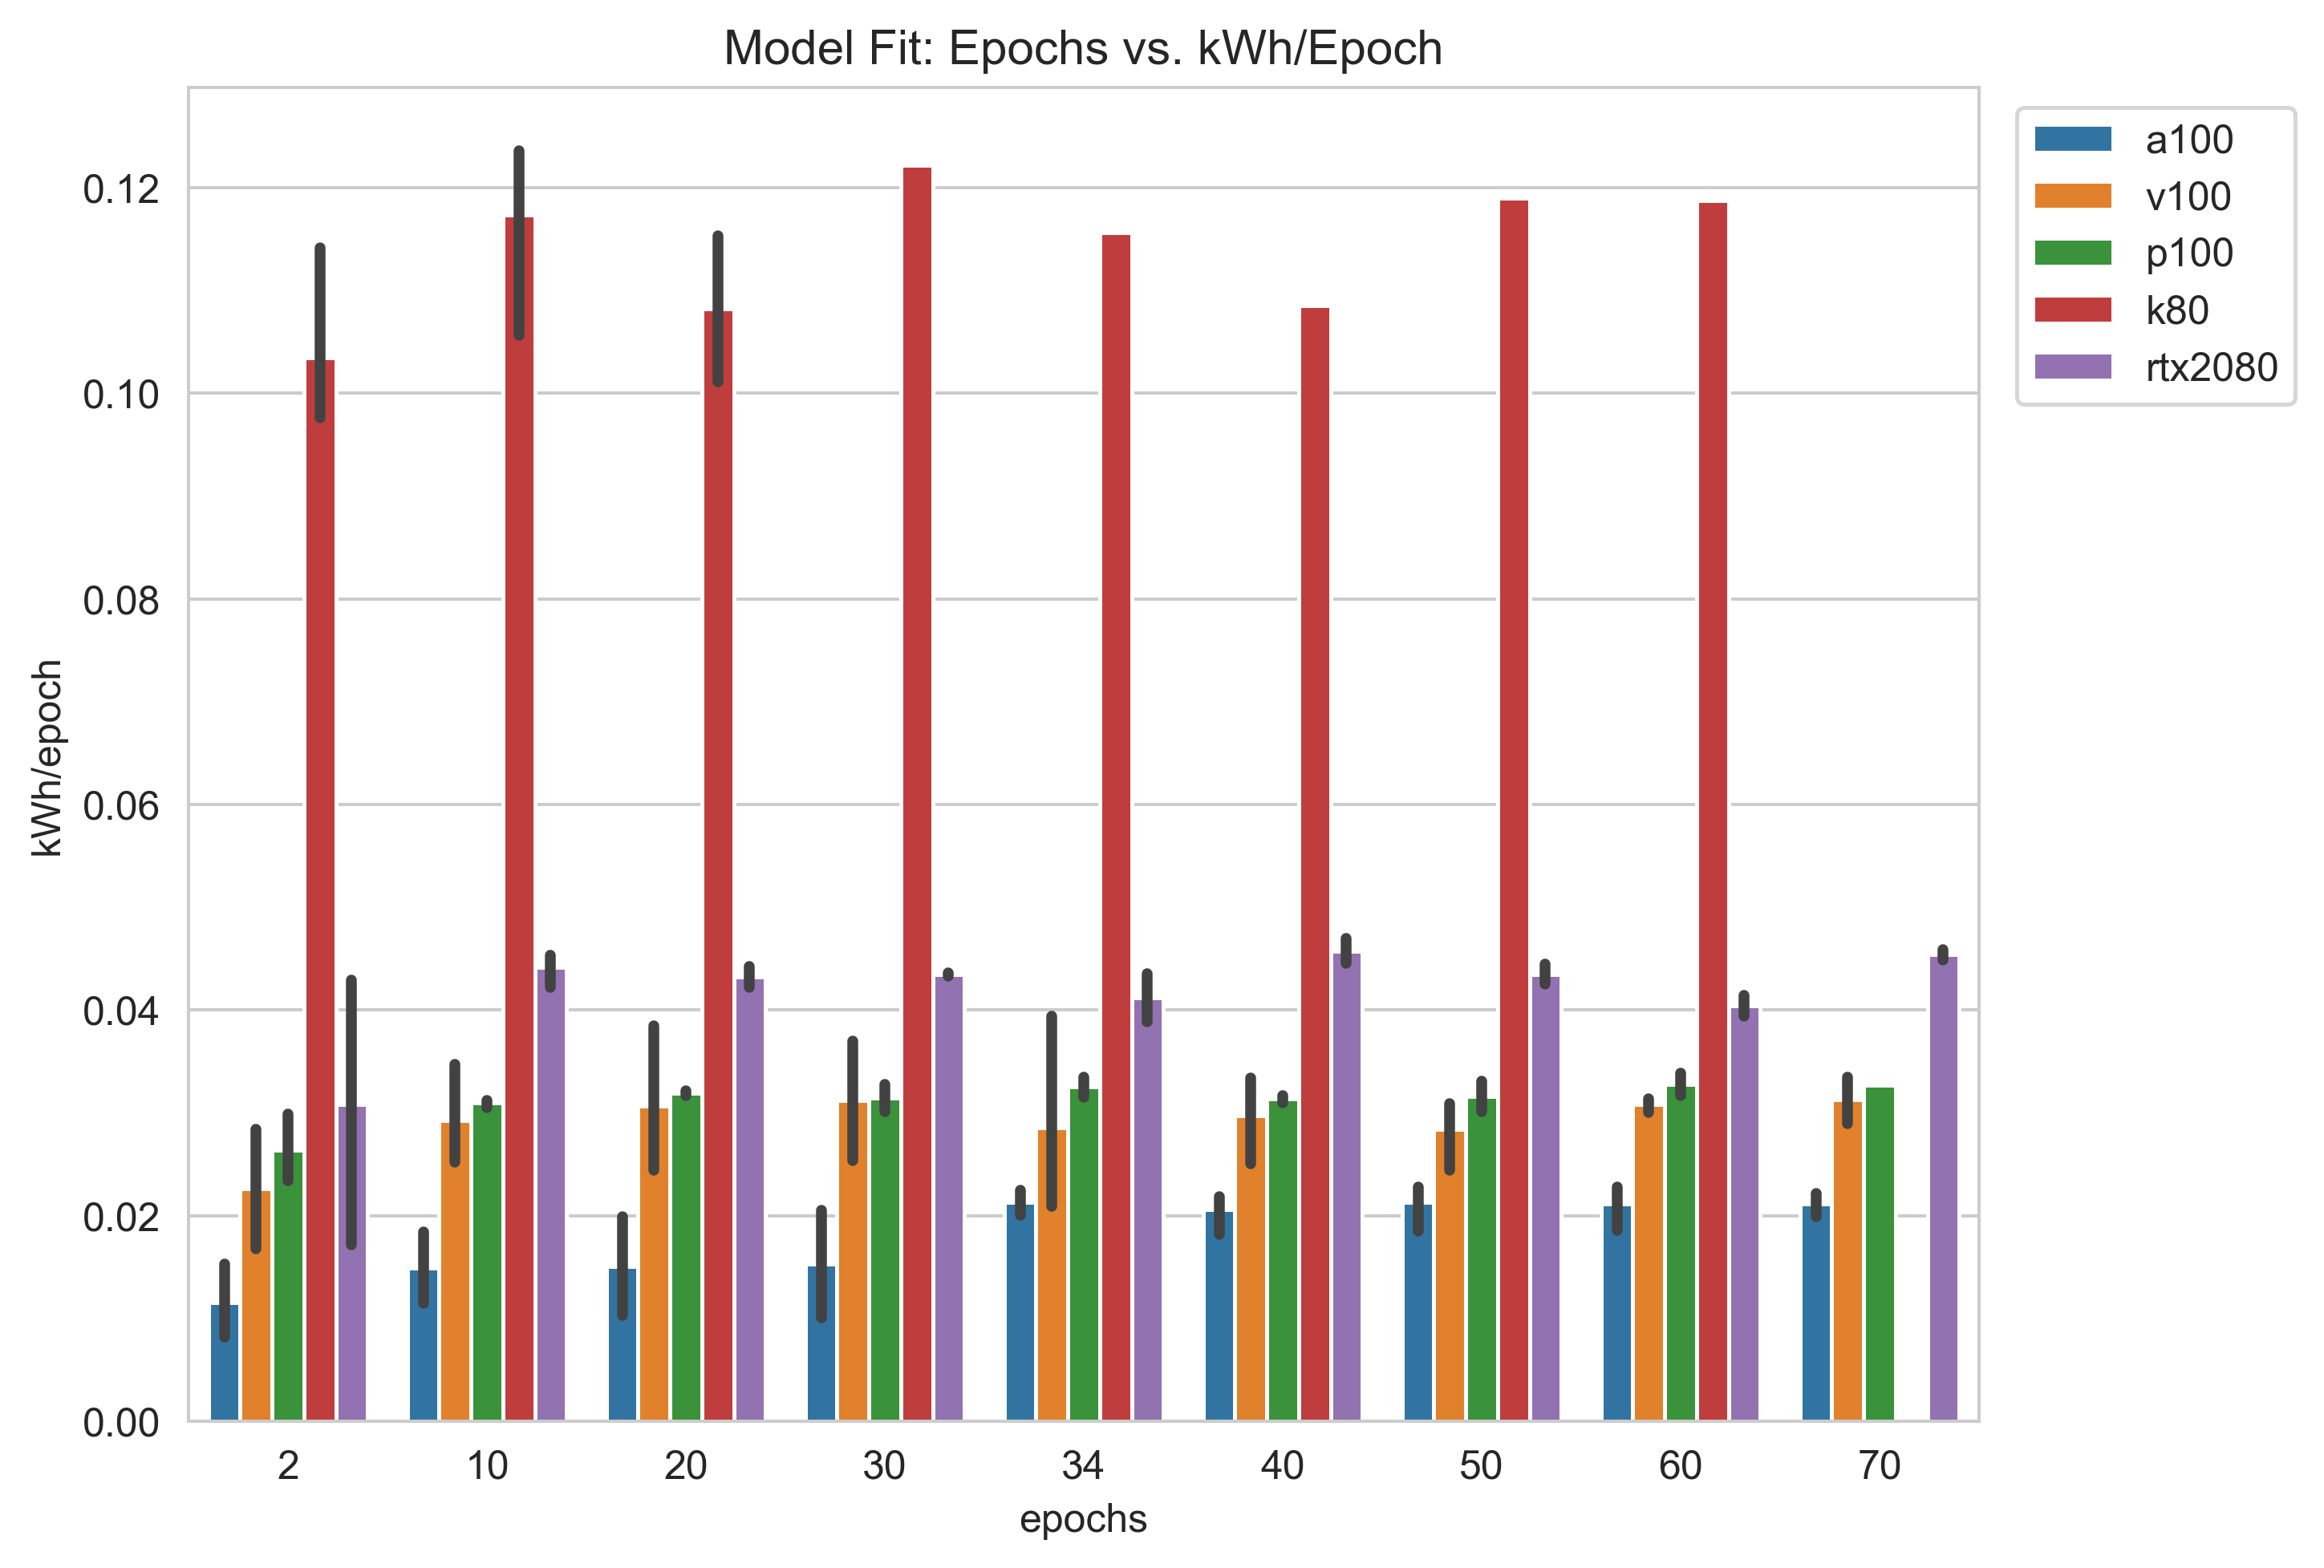

C:\Users\Rober\AppData\Local\Temp\ipykernel_23492\1368567041.py:52: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped = df.groupby('gpu').mean()['kWh/epoch_fit'].reset_index()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


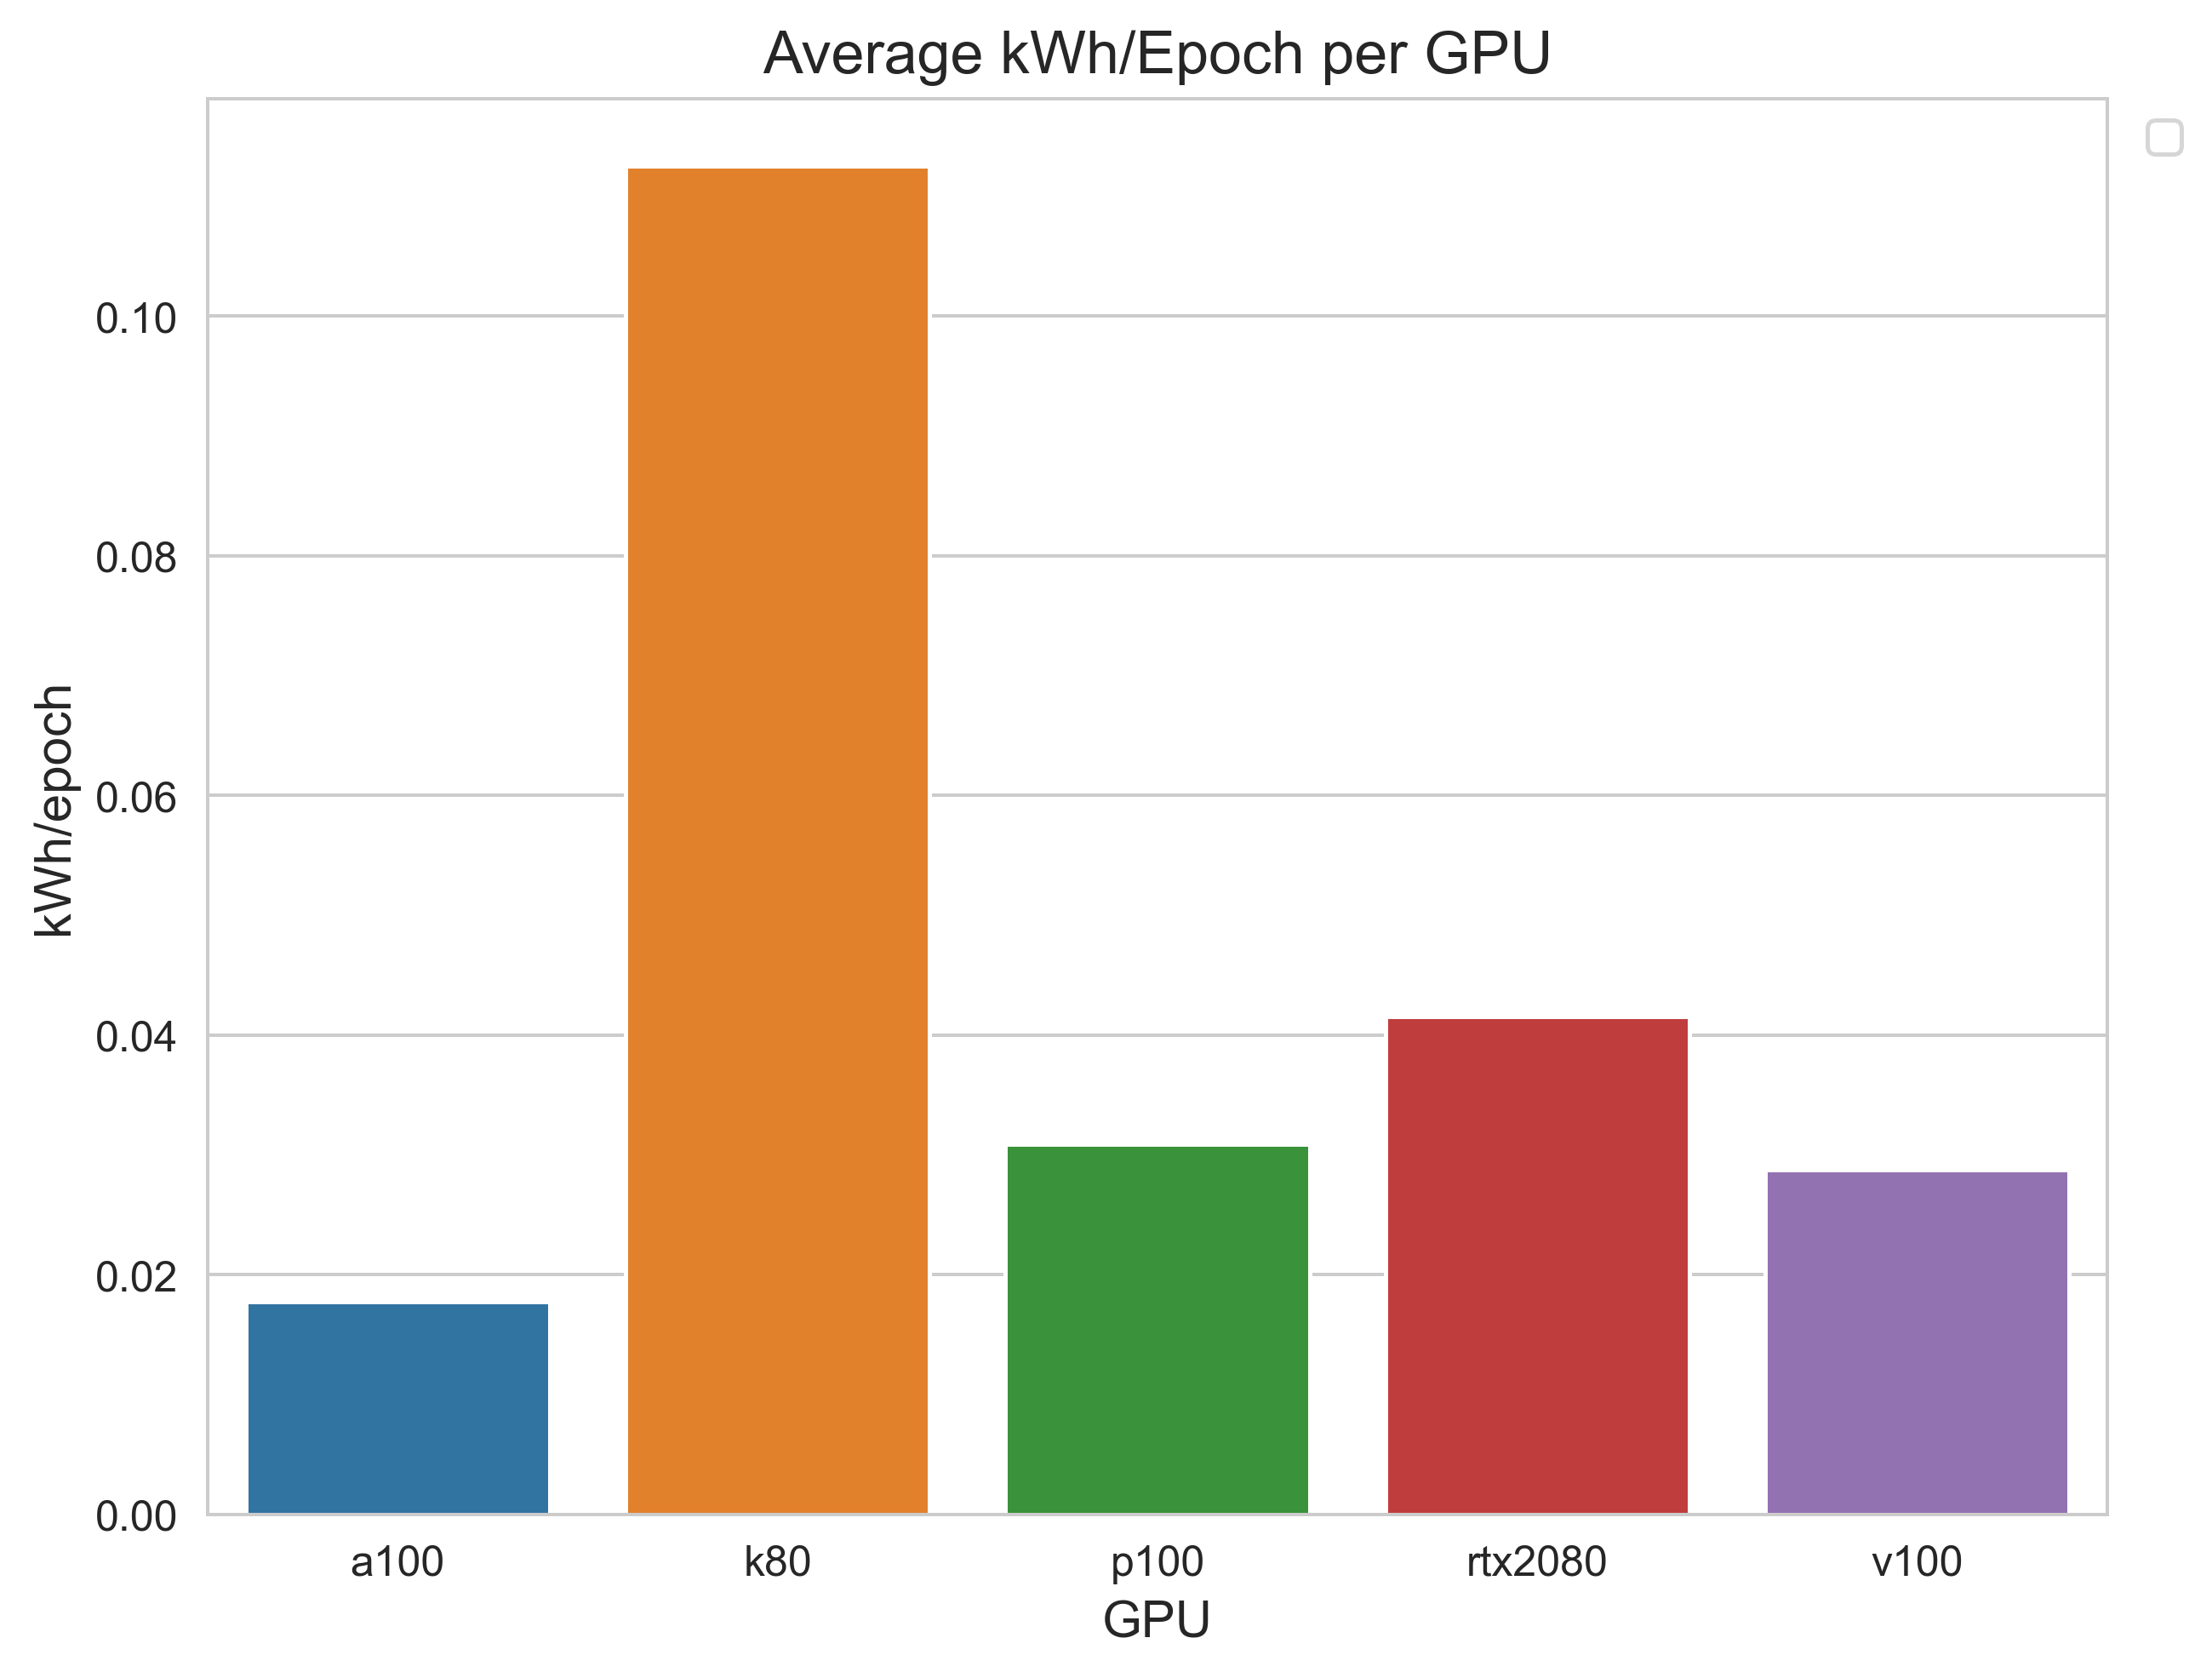

In [7]:
analysis_path = os.path.join(os.getcwd(),'analysis')

power_df = pd.DataFrame()
for experiment in loaded_dict.keys():
    power_data = loaded_dict[experiment]['power_df']
    if power_data is not None:
        power_df = pd.concat([power_df,power_data])

# power usage plots
plot_power_usage(power_df, analysis_path, span='total', normalize=False)
plot_power_usage(power_df, analysis_path, span='total', normalize=True)
plot_power_usage(power_df, analysis_path, span='train', normalize=False)
plot_power_usage(power_df, analysis_path, span='train', normalize=True)
plot_power_usage(power_df, analysis_path, span='avg', normalize=True)

In [8]:
power_df

,gpu,numGpus,numCpus,mem,epochs,kWh_total,kWh_fit,kWh/epoch_total,kWh/epoch_fit
0,a100,1,6,32GB,20,0.344482,0.205398,0.017224,0.010270
0,a100,1,6,32GB,50,1.431632,1.140884,0.028633,0.022818
0,a100,1,6,32GB,70,1.863218,1.549198,0.026617,0.022131
0,a100,1,6,32GB,30,0.444316,0.301114,0.014811,0.010037
0,a100,1,6,32GB,2,0.159803,0.015096,0.079902,0.007548
...,...,...,...,...,...,...,...,...,...
0,v100,1,6,32GB,10,0.587319,0.271590,0.058732,0.027159
0,v100,1,6,32GB,30,1.186723,0.887554,0.039557,0.029585
0,v100,1,6,32GB,20,0.874866,0.566679,0.043743,0.028334
0,v100,1,6,32GB,40,1.506614,1.195490,0.037665,0.029887


In [9]:
loaded_dict['card_name_1_gpu_count_1_cpu_num_6_mem_32GB_TFTTransformerepochs_20.rivanna_dgx.localscratch.2022-07-13']['gpu_df']

,time,id,gpu_util %,memory_util %,encoder_util %,decoder_util %,gpu_temp C,power_draw W
0,2022-07-11:22:44:06.784415,0,0,0,0,0,31,62.47
1,2022-07-11:22:44:09.097969,0,0,0,0,0,31,62.47
2,2022-07-11:22:44:11.427877,0,0,0,0,0,31,62.47
3,2022-07-11:22:44:15.588966,0,0,0,0,0,31,62.47
4,2022-07-11:22:44:18.608242,0,0,0,0,0,31,62.47
...,...,...,...,...,...,...,...,...
12715,2022-07-12:06:21:16.715516,0,0,0,0,0,30,68.44
12716,2022-07-12:06:21:18.906029,0,0,0,0,0,30,68.51
12717,2022-07-12:06:21:21.093519,0,0,0,0,0,30,68.18
12718,2022-07-12:06:21:23.278333,0,0,0,0,0,31,86.61


In [10]:
localscratch_observations = ("localscratch", )
project_observations = ("project", )


power_df_localscratch = pd.DataFrame()
power_df_project = pd.DataFrame()
for experiment in loaded_dict.keys():
    for system_extraction in localscratch_observations:
        filesystem = loaded_dict[experiment]['run_info']['filesystem']
        if system_extraction == filesystem:
            power_data = loaded_dict[experiment]['power_df']
            if power_data is not None:
                power_df_localscratch = pd.concat([power_df_localscratch, power_data])
    for system_extraction in project_observations:
        system = loaded_dict[experiment]['run_info']['filesystem']
        if system_extraction == filesystem:
            power_data = loaded_dict[experiment]['power_df']
            if power_data is not None:
                power_df_project = pd.concat([power_df_project, power_data])

In [11]:
power_df_project

,gpu,numGpus,numCpus,mem,epochs,kWh_total,kWh_fit
0,v100,1,6,32GB,2,0.225193,0.024044
0,p100,1,6,32GB,10,0.512687,0.311262
0,k80,1,6,32GB,2,0.577035,0.195143
0,v100,1,6,32GB,10,0.577213,0.274995
0,rtx2080,1,6,32GB,2,0.245610,0.034389
0,rtx2080,1,6,32GB,10,0.692504,0.422140
0,a100,1,6,32GB,10,0.464943,0.188733
0,k80,1,6,32GB,10,1.648363,1.222264
0,a100,1,6,32GB,2,0.292816,0.021699
0,p100,1,6,32GB,2,0.269074,0.051459


In [12]:
power_df_localscratch

,gpu,numGpus,numCpus,mem,epochs,kWh_total,kWh_fit
0,a100,1,6,32GB,20,0.344482,0.205398
0,a100,1,6,32GB,50,1.431632,1.140884
0,a100,1,6,32GB,70,1.863218,1.549198
0,a100,1,6,32GB,30,0.444316,0.301114
0,a100,1,6,32GB,2,0.159803,0.015096
0,a100,1,6,32GB,34,1.059791,0.764437
0,a100,1,6,32GB,40,1.185746,0.875204
0,a100,1,6,32GB,10,0.241748,0.099891
0,a100,1,6,32GB,60,1.651901,1.367174
0,a100,1,6,32GB,20,0.344482,0.205398


In [13]:
a100_localscratch = dict()
for epoch in (2, 30, 70):
    a100_localscratch[epoch] = power_df_localscratch.loc[(power_df_localscratch["gpu"] == "a100") & (power_df_localscratch["epochs"] == str(epoch))]
    display(a100_localscratch[epoch])

,gpu,numGpus,numCpus,mem,epochs,kWh_total,kWh_fit
0,a100,1,6,32GB,2,0.159803,0.015096
0,a100,1,6,32GB,2,0.159803,0.015096


,gpu,numGpus,numCpus,mem,epochs,kWh_total,kWh_fit
0,a100,1,6,32GB,30,0.444316,0.301114
0,a100,1,6,32GB,30,0.444316,0.301114


,gpu,numGpus,numCpus,mem,epochs,kWh_total,kWh_fit
0,a100,1,6,32GB,70,1.863218,1.549198
0,a100,1,6,32GB,70,1.863218,1.549198


In [14]:
v100_localscratch = dict()
for epoch in (2, 30, 70):
    v100_localscratch[epoch] = power_df_localscratch.loc[(power_df_localscratch["gpu"] == "v100") & (power_df_localscratch["epochs"] == str(epoch))]
    display(v100_localscratch[epoch])

,gpu,numGpus,numCpus,mem,epochs,kWh_total,kWh_fit
0,v100,1,6,32GB,2,0.335139,0.064743
0,v100,1,6,32GB,2,0.320389,0.057719
0,v100,1,6,32GB,2,0.350819,0.028224


,gpu,numGpus,numCpus,mem,epochs,kWh_total,kWh_fit
0,v100,1,6,32GB,30,1.994999,1.183086
0,v100,1,6,32GB,30,1.186723,0.887554


,gpu,numGpus,numCpus,mem,epochs,kWh_total,kWh_fit
0,v100,1,6,32GB,70,2.459698,2.198873


In [15]:
a100_project = dict()
for epoch in (2, 30, 70):
    a100_project[epoch] = power_df_project.loc[(power_df_project["gpu"] == "a100") & (power_df_project["epochs"] == str(epoch))]
    display(a100_localscratch[epoch])

,gpu,numGpus,numCpus,mem,epochs,kWh_total,kWh_fit
0,a100,1,6,32GB,2,0.159803,0.015096
0,a100,1,6,32GB,2,0.159803,0.015096


,gpu,numGpus,numCpus,mem,epochs,kWh_total,kWh_fit
0,a100,1,6,32GB,30,0.444316,0.301114
0,a100,1,6,32GB,30,0.444316,0.301114


,gpu,numGpus,numCpus,mem,epochs,kWh_total,kWh_fit
0,a100,1,6,32GB,70,1.863218,1.549198
0,a100,1,6,32GB,70,1.863218,1.549198


In [16]:
v100_project = dict()
for epoch in (2, 30, 70):
    v100_project[epoch] = power_df_project.loc[(power_df_project["gpu"] == "v100") & (power_df_project["epochs"] == str(epoch))]
    display(v100_project[epoch])

,gpu,numGpus,numCpus,mem,epochs,kWh_total,kWh_fit
0,v100,1,6,32GB,2,0.225193,0.024044


,gpu,numGpus,numCpus,mem,epochs,kWh_total,kWh_fit


,gpu,numGpus,numCpus,mem,epochs,kWh_total,kWh_fit
